In [1]:
## First step cleaning goal:
# filter papers with english lang, keywords, abstract, references, and issn
# save papers to according published year
# get paper_info dataframe for next step
import re
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import math

In [2]:

journal_dir = "..\\data\\scopus"
dat = pd.read_csv(journal_dir+'\\'+'journal_subject.csv',keep_default_na = False)

print(dat.dtypes)
all_issn = []
all_issn.append(dat['Print-ISSN'].unique())
all_issn.append(dat['E-ISSN'].unique())
all_issn = [i for sub in all_issn for i in sub]

## Get the dictionary of issn: list of subject
issn_subject = {}
for i in range(dat.shape[0]):

    if dat.iloc[i,5] not in issn_subject:
        issn_subject[dat.iloc[i,5]] = [dat.iloc[i,3]]
    else:
        issn_subject[dat.iloc[i,5]].append(dat.iloc[i,3])
    if dat.iloc[i,6] not in issn_subject:
        issn_subject[dat.iloc[i,6]] = [dat.iloc[i,3]]
    else:
        issn_subject[dat.iloc[i,6]].append(dat.iloc[i,3])
## delete na key
del issn_subject[""]

Title                                  object
Publisher                              object
Type                                   object
Scopus ASJC Code (Sub-subject Area)     int64
Scopus Sub-Subject Area                object
Print-ISSN                             object
E-ISSN                                 object
dtype: object


8271

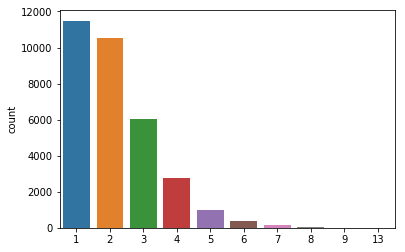

In [16]:
sns.countplot([len(v) for k,v in issn_subject.items()])
a = np.array([v for k,v in issn_subject.items()])[np.array([len(v) for k,v in issn_subject.items()])==2]

In [3]:
## math cs linguistic
# issn_match = []
# for issn in issn_subject:
#     num = np.array(issn_subject[issn])
#     if 26 in num//100 or 17 in num//100 or 26 in num//100:
#         issn_match.append(issn)
# journal = Counter()
# for i in range(dat.shape[0]):
#     if dat.iloc[i,5] in issn_match or dat.iloc[i,6] in issn_match:
#         if dat.iloc[i,0] not in journal:
#             journal[dat.iloc[i,0]] = 1

In [4]:
data_dir = "..\\data"
file_names = os.listdir(data_dir)[:-4]
os.listdir(data_dir)[-4:]

['by_year', 'mag', 'sample', 'scopus']

In [6]:
## set up folder like following
## -data
##   -by_year
##   aminer_paper_0.txt ...

data_dir = "..\\data"
## only keep data file, exclude folds
file_names = os.listdir(data_dir)[:-4]

## output file  
years = np.arange(1990,2020)
out_dir = "..\\data\\by_year"
out_names = ['aminer_'+str(i)+'.txt' for i in years]
out_f = [open(out_dir+'\\'+name, 'w') for name in out_names]

## paper subject table
id_t = []
year_t = []
references_t = []
issn_t = []
subjects_t = []

for file in file_names:
    print('filtering file:',file)
    f = open(data_dir+'\\'+file,'r',encoding = 'utf8')
    
    for i, line in enumerate(f):
        if (i+2) % 250000 == 0:
            print('file '+file+': ',round((i+2)/1000000*100,1),"%")
        json_line = json.loads(line)
        if 'year' in json_line and 'keywords' in json_line and \
        'abstract' in json_line and 'lang' in json_line and \
        'references' in json_line and 'issn' in json_line:
            
            issn = re.sub('-','',json_line['issn'])
            year = json_line['year']
            if json_line['lang'] == 'en' and issn in issn_subject and \
            year >= 1990 and year <= 2019 :
                
                ## store paper info, later use to get the subject of the paper
                id_t.append(json_line['id'])
                year_t.append(json_line['year'])
                references_t.append(json_line['references'])
                issn_t.append(issn)
                subjects_t.append(issn_subject[issn])
                
                ## write to paper_year
                index = out_names.index('aminer_'+str(year)+'.txt')
                out_f[index].write(line)
    f.close()
    
for out in out_f:
    out.close()


filtering file: aminer_papers_0.txt
file aminer_papers_0.txt:  25.0 %
file aminer_papers_0.txt:  50.0 %
file aminer_papers_0.txt:  75.0 %
file aminer_papers_0.txt:  100.0 %
filtering file: aminer_papers_1.txt
file aminer_papers_1.txt:  25.0 %
file aminer_papers_1.txt:  50.0 %
file aminer_papers_1.txt:  75.0 %
file aminer_papers_1.txt:  100.0 %
filtering file: aminer_papers_10.txt
file aminer_papers_10.txt:  25.0 %
file aminer_papers_10.txt:  50.0 %
file aminer_papers_10.txt:  75.0 %
file aminer_papers_10.txt:  100.0 %
filtering file: aminer_papers_100.txt
file aminer_papers_100.txt:  25.0 %
file aminer_papers_100.txt:  50.0 %
file aminer_papers_100.txt:  75.0 %
file aminer_papers_100.txt:  100.0 %
filtering file: aminer_papers_101.txt
file aminer_papers_101.txt:  25.0 %
file aminer_papers_101.txt:  50.0 %
file aminer_papers_101.txt:  75.0 %
file aminer_papers_101.txt:  100.0 %
filtering file: aminer_papers_102.txt
file aminer_papers_102.txt:  25.0 %
file aminer_papers_102.txt:  50.0 %


file aminer_papers_139.txt:  25.0 %
file aminer_papers_139.txt:  50.0 %
file aminer_papers_139.txt:  75.0 %
file aminer_papers_139.txt:  100.0 %
filtering file: aminer_papers_14.txt
file aminer_papers_14.txt:  25.0 %
file aminer_papers_14.txt:  50.0 %
file aminer_papers_14.txt:  75.0 %
file aminer_papers_14.txt:  100.0 %
filtering file: aminer_papers_140.txt
file aminer_papers_140.txt:  25.0 %
file aminer_papers_140.txt:  50.0 %
file aminer_papers_140.txt:  75.0 %
file aminer_papers_140.txt:  100.0 %
filtering file: aminer_papers_141.txt
file aminer_papers_141.txt:  25.0 %
file aminer_papers_141.txt:  50.0 %
file aminer_papers_141.txt:  75.0 %
file aminer_papers_141.txt:  100.0 %
filtering file: aminer_papers_142.txt
file aminer_papers_142.txt:  25.0 %
file aminer_papers_142.txt:  50.0 %
file aminer_papers_142.txt:  75.0 %
file aminer_papers_142.txt:  100.0 %
filtering file: aminer_papers_143.txt
file aminer_papers_143.txt:  25.0 %
file aminer_papers_143.txt:  50.0 %
file aminer_papers

file aminer_papers_41.txt:  25.0 %
file aminer_papers_41.txt:  50.0 %
file aminer_papers_41.txt:  75.0 %
file aminer_papers_41.txt:  100.0 %
filtering file: aminer_papers_42.txt
file aminer_papers_42.txt:  25.0 %
file aminer_papers_42.txt:  50.0 %
file aminer_papers_42.txt:  75.0 %
file aminer_papers_42.txt:  100.0 %
filtering file: aminer_papers_43.txt
file aminer_papers_43.txt:  25.0 %
file aminer_papers_43.txt:  50.0 %
file aminer_papers_43.txt:  75.0 %
file aminer_papers_43.txt:  100.0 %
filtering file: aminer_papers_44.txt
file aminer_papers_44.txt:  25.0 %
file aminer_papers_44.txt:  50.0 %
file aminer_papers_44.txt:  75.0 %
file aminer_papers_44.txt:  100.0 %
filtering file: aminer_papers_45.txt
file aminer_papers_45.txt:  25.0 %
file aminer_papers_45.txt:  50.0 %
file aminer_papers_45.txt:  75.0 %
file aminer_papers_45.txt:  100.0 %
filtering file: aminer_papers_46.txt
file aminer_papers_46.txt:  25.0 %
file aminer_papers_46.txt:  50.0 %
file aminer_papers_46.txt:  75.0 %
file 

file aminer_papers_83.txt:  50.0 %
file aminer_papers_83.txt:  75.0 %
file aminer_papers_83.txt:  100.0 %
filtering file: aminer_papers_84.txt
file aminer_papers_84.txt:  25.0 %
file aminer_papers_84.txt:  50.0 %
file aminer_papers_84.txt:  75.0 %
file aminer_papers_84.txt:  100.0 %
filtering file: aminer_papers_85.txt
file aminer_papers_85.txt:  25.0 %
file aminer_papers_85.txt:  50.0 %
file aminer_papers_85.txt:  75.0 %
file aminer_papers_85.txt:  100.0 %
filtering file: aminer_papers_86.txt
file aminer_papers_86.txt:  25.0 %
file aminer_papers_86.txt:  50.0 %
file aminer_papers_86.txt:  75.0 %
file aminer_papers_86.txt:  100.0 %
filtering file: aminer_papers_87.txt
file aminer_papers_87.txt:  25.0 %
file aminer_papers_87.txt:  50.0 %
file aminer_papers_87.txt:  75.0 %
file aminer_papers_87.txt:  100.0 %
filtering file: aminer_papers_88.txt
file aminer_papers_88.txt:  25.0 %
file aminer_papers_88.txt:  50.0 %
file aminer_papers_88.txt:  75.0 %
file aminer_papers_88.txt:  100.0 %
filt

In [7]:
paper_info = pd.DataFrame({'id':id_t,'year':year_t,'refereneces':references_t,'issn':issn_t,'subjects':subjects_t})
paper_info.to_csv(out_dir+'\\paper_info_1990.csv',index = False)
paper_info.head()

###################### First step cleaning stop here ###########################

,id,year,refereneces,issn,subjects
0,53e99784b7602d9701f3e13e,2011,"[53e99b4ab7602d97023ea8fd, 53e997f8b7602d9701f...",15734919,"[1308, 1312, 1307]"
1,53e99784b7602d9701f3e4f2,2002,"[53e9a611b7602d9702f42159, 53e9b316b7602d9703d...",10761551,"[2716, 1311, 1313, 1312]"
2,53e9978db7602d9701f4f415,2005,"[53e9aa41b7602d97033af1b3, 53e9b1b0b7602d9703c...",12138118,[1300]
3,53e99792b7602d9701f56a86,2004,"[53e9abbeb7602d970356d932, 53e9ad6cb7602d97037...",00195545,[2738]
4,53e99792b7602d9701f5af0e,1993,"[53e99d04b7602d97025b8c26, 53e9a945b7602d97032...",09368051,"[2746, 2732]"


In [4]:
## Refer to paper_subject.ipynb for second step
## Second step goal:
##  Use paper_info to get the subject of each paper

################################### DO NOT RUN FOLLOWING BLOCKS #############################
out_dir = "..\\data\\by_year"
paper_info = pd.read_csv(out_dir+'\\paper_info_1990.csv',index_col = 'id')

In [6]:
paper_info.head()
paper_info.shape

(2991003, 4)

2013    242323
2014    234254
2012    204966
2011    198143
2008    190612
2007    185136
2006    173425
2009    171783
2010    170176
2005    154472
2004    134476
2003    117503
2002    106088
2015     95422
2001     89239
2000     84805
1999     72036
1998     65032
1997     55626
1996     47803
1995     44278
1994     36002
1993     32035
1992     30755
1991     28054
1990     26555
2016         4
Name: year, dtype: int64

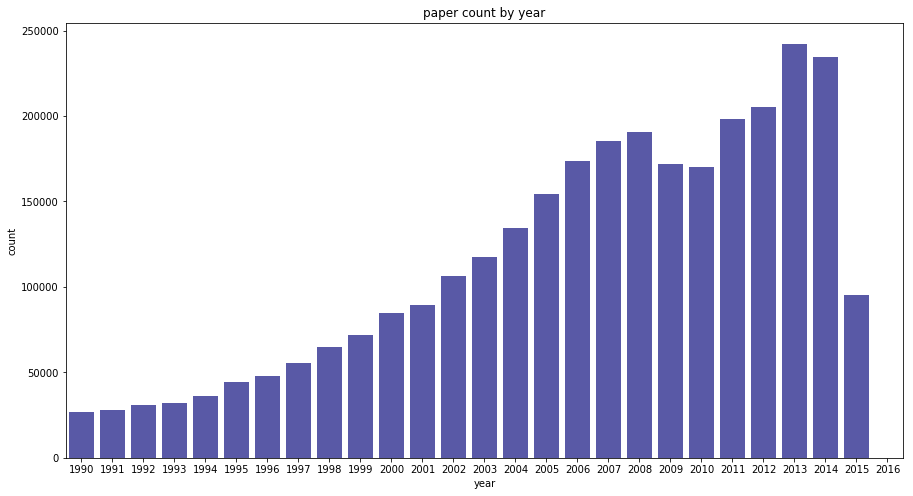

In [8]:
plt.figure(figsize=(15,8))
plt.title("paper count by year")
ax = sns.countplot(x = 'year', data = paper_info,color = 'b',saturation = 0.3)
paper_info['year'].value_counts()

In [ ]:
i = 4
def get_subject_num(i):
    ##take in index of paper_info, return 2 digits subject code
    ## if journal has only one subject, return the subject num
    sub_num = [int(s.strip(" [],")) for s in paper_info.iloc[i,2].split(",") if s.strip(" [],") != ""]
    if len(sub_num) == 1:
        return sub_num[0]//100
    else:
        has_ref = False
        subject_list = []
        ref_list = [s.strip(" [],") for s in paper_info.iloc[i,1].split("'") if s.strip(" [],") != ""]
        for ref in ref_list:
            if ref in paper_info.index:
                has_ref = True
                sub_num_list = [int(s.strip(" [],")) for s in paper_info.loc[ref][2].split(",") if s.strip(" [],") != ""]
                subject_list += sub_num 
                count_subject = Counter(np.array(subject_list)//100)
        ## Elements with equal counts are ordered and chose arbitrarily
        if has_ref:
            return count_subject.most_common(1)[0][0]
        else:
            return None
get_subject_num(i)

In [ ]:
paper_subject = []
for i in range(paper_info.shape[0]):
    if i == 30000: break
    paper_subject.append(get_subject_num(i))
len(paper_subject)

In [ ]:
plt.figure(figsize=(15,6))
plt.title("paper subject count")
ax = sns.countplot(x = paper_subject)